In [1]:
import pandas  as pd
import numpy as np
import random 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import chain
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data =pd.read_csv("./dataset/train.csv", nrows = 100000)
destinations_data =pd.read_csv("./dataset/destinations.csv", nrows = 100000)

In [3]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


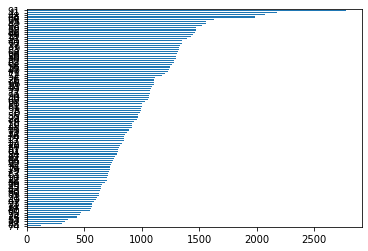

In [6]:
train_data.hotel_cluster.value_counts().sort_values().plot(kind = 'barh')

### The hotel cluster 91 has more no of visits

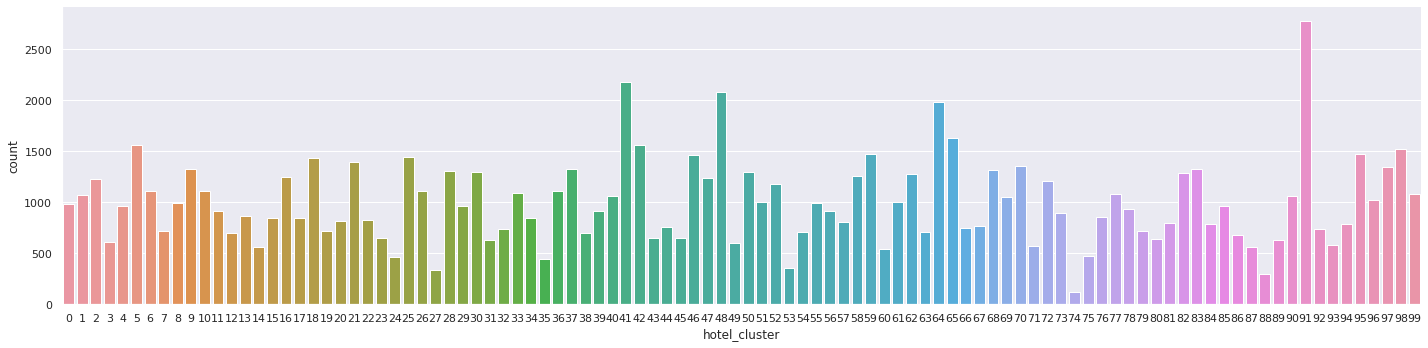

In [7]:
sns.set_theme(style="darkgrid")
sns.catplot(x="hotel_cluster", data=train_data, kind='count', aspect = 4)

### To get more insights, we are adding year and month extracted from date_time attribute

In [4]:
train_data["date_time"] = pd.to_datetime(train_data["date_time"])
train_data["month"] = train_data["date_time"].dt.month
train_data["year"] = train_data["date_time"].dt.year

In [5]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,year
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,8,2014
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,1,1,2,50,628,1,8,2014
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,8250,1,0,1,2,50,628,1,8,2014
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,14984,1,0,1,2,50,1457,80,8,2014
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,14984,1,0,1,2,50,1457,21,8,2014


#### The training data has no linear correlation with any attributes in the dataset.

In [10]:
train_data.corr()["hotel_cluster"]

site_name                   -0.019154
posa_continent               0.002204
user_location_country       -0.025170
user_location_region         0.008037
user_location_city          -0.006580
orig_destination_distance    0.011362
user_id                      0.001396
is_mobile                   -0.002803
is_package                   0.051955
channel                     -0.005956
srch_adults_cnt              0.007322
srch_children_cnt            0.005469
srch_rm_cnt                 -0.005801
srch_destination_id         -0.007258
srch_destination_type_id    -0.030064
is_booking                  -0.025380
cnt                          0.000914
hotel_continent             -0.008441
hotel_country               -0.021170
hotel_market                 0.036107
hotel_cluster                1.000000
month                        0.001208
year                         0.000696
Name: hotel_cluster, dtype: float64

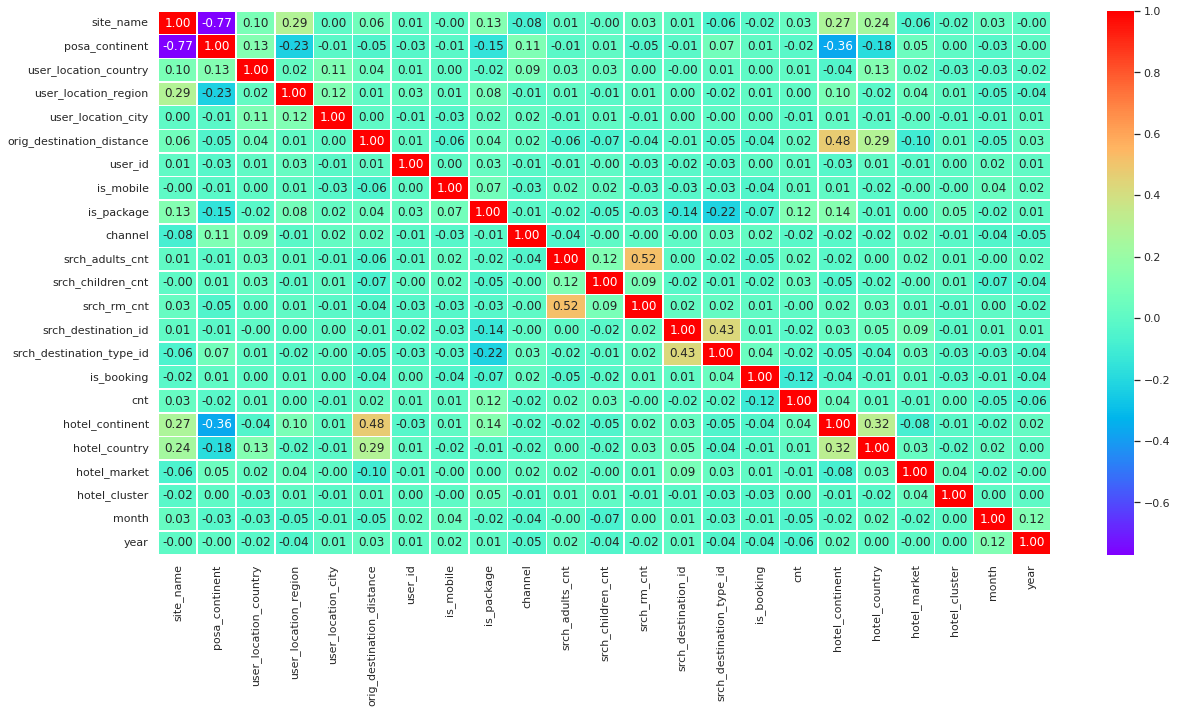

In [11]:
corr = train_data.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(round(corr, 2).iloc[:, :], annot=True, linewidths=.5, ax=ax, cmap="rainbow",fmt='.2f')

In [6]:
users_uni = train_data.user_id.unique()  
sampled_userids = []
for k in sorted(random.sample(range(len(users_uni)),100)):
    sampled_userids.append(users_uni[k])
    
sampled_train = train_data[train_data.user_id.isin(sampled_userids)]
sampled_train

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,year
894,2013-06-18 08:17:00,37,1,69,923,15777,NaN,6300,0,0,...,30793,4,0,2,2,50,666,78,6,2013
895,2014-06-09 10:55:52,37,1,69,923,35532,NaN,6300,0,1,...,9927,1,0,1,6,170,11,64,6,2014
896,2014-06-10 12:43:04,37,1,69,923,35532,NaN,6300,0,1,...,8252,1,0,1,6,170,313,64,6,2014
897,2014-06-10 12:46:40,37,1,69,923,35532,NaN,6300,0,0,...,9927,1,0,2,6,170,11,64,6,2014
898,2014-06-18 08:59:17,37,1,69,727,29821,NaN,6300,0,1,...,8252,1,0,1,6,170,313,64,6,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97791,2013-11-06 18:14:38,2,3,66,149,50689,NaN,383420,0,0,...,5175,3,1,1,2,50,647,68,11,2013
98722,2014-12-22 13:36:22,37,1,69,682,49703,NaN,385081,0,1,...,531,3,0,1,6,105,12,58,12,2014
98723,2014-12-22 13:41:54,37,1,69,682,49703,NaN,385081,0,1,...,531,3,0,1,6,105,12,58,12,2014
98724,2014-12-22 13:42:46,37,1,69,682,49703,NaN,385081,0,1,...,531,3,0,2,6,105,12,64,12,2014


#### The data is split in training and testing. As test.csv contains data aged above 2014, the testing_set has been sampled accordingly

In [7]:
training_set = sampled_train[(((sampled_train.month < 8) & (sampled_train.year == 2014)) | (sampled_train.year == 2013))]
testing_set = sampled_train[((sampled_train.month >= 8) & (sampled_train.year == 2014))]

In [8]:
training_set.shape, testing_set.shape

((2081, 26), (980, 26))

In [9]:
testing_set = testing_set[testing_set.is_booking == True]
testing_set.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,year
3192,2014-12-25 15:54:58,2,3,3,50,5703,NaN,16167,0,0,...,8747,1,1,1,3,106,107,85,12,2014
4151,2014-09-28 12:16:05,2,3,66,174,21942,1941.8835,25159,0,0,...,43055,6,1,1,2,50,350,18,9,2014
4153,2014-09-28 12:53:12,2,3,66,174,21942,109.8043,25159,0,0,...,8278,1,1,1,2,50,368,91,9,2014
5087,2014-12-10 11:14:41,2,3,66,363,25671,105.9449,31638,0,0,...,45631,6,1,1,2,50,675,21,12,2014
5106,2014-12-29 12:19:28,2,3,66,363,25671,105.9578,31638,0,0,...,45631,6,1,1,2,50,675,70,12,2014


#### Initially setting the recommended cluster values based on their value counts

In [10]:
initial_cluster_values = list(train_data.hotel_cluster.value_counts().head().index)
initial_cluster_values

[91, 41, 48, 64, 65]

In [11]:
top_five_clusters = []
clusters_count = testing_set.shape[0]
for cluster in range(clusters_count):
    top_five_clusters.append(initial_cluster_values)

In [12]:
training_set['hotel_cluster']

894      78
895      64
896      64
897      64
898      64
         ..
97249    50
97250    50
97789    68
97790    68
97791    68
Name: hotel_cluster, Length: 2081, dtype: int64

In [13]:
destinations_data.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [14]:
pca = PCA(n_components=3)  
reduced_dest = pca.fit_transform(destinations_data[["d{0}".format(i+1) for i in range(149)]])
reduced_dest = pd.DataFrame(reduced_dest)  
reduced_dest["srch_destination_id"]= destinations_data["srch_destination_id"]

In [15]:
reduced_dest

,0,1,2,srch_destination_id
0,-0.044268,0.169419,0.032519,0
1,-0.440761,0.077405,-0.091573,1
2,0.001033,0.020677,0.012111,2
3,-0.480467,-0.040345,-0.019320,3
4,-0.207253,-0.042694,-0.011744,4
...,...,...,...,...
62101,0.031398,-0.191479,-0.064768,64989
62102,0.071925,-0.174147,0.071126,64990
62103,0.166190,0.208037,0.217178,64991
62104,-0.581395,-0.027664,-0.054206,64992


In [16]:
def features_imp(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    attributes = {}
    for col in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        attributes[col] = getattr(df["date_time"].dt, col)
    
    extra_attr = []
    for col in df.columns:
        if col not in ["srch_ci", "date_time", "srch_co"]:
            extra_attr.append(col)
            
    for attr in extra_attr:
        attributes[attr] = df[attr]
    
    feature_dates = ["month", "day", "dayofweek", "quarter"]
    for attr in feature_dates:
        attributes["ci_{0}".format(attr)] = getattr(df["srch_ci"].dt, attr)
        attributes["co_{0}".format(attr)] = getattr(df["srch_co"].dt, attr)
    attributes["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    updated_df = pd.DataFrame(attributes)
    updated_df = updated_df.join(reduced_dest, on="srch_destination_id", how='left', rsuffix="dest")
    updated_df = updated_df.drop("srch_destination_iddest", axis=1)
    return updated_df

In [17]:
new_df = features_imp(training_set)
new_df.fillna(-1, inplace=True)

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [18]:
new_df

,month,day,hour,minute,dayofweek,quarter,site_name,posa_continent,user_location_country,user_location_region,...,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,stay_span,0,1,2
894,6,18,8,17,1,2,37,1,69,923,...,15.0,22.0,2.0,2.0,1.0,1.0,168.0,0.130653,-0.025749,-0.161131
895,6,9,10,55,0,2,37,1,69,923,...,7.0,14.0,0.0,0.0,3.0,3.0,168.0,-0.234711,0.001544,0.106205
896,6,10,12,43,1,2,37,1,69,923,...,9.0,11.0,2.0,4.0,3.0,3.0,48.0,0.431290,0.008831,0.386439
897,6,10,12,46,1,2,37,1,69,923,...,9.0,14.0,2.0,0.0,3.0,3.0,120.0,-0.234711,0.001544,0.106205
898,6,18,8,59,2,2,37,1,69,727,...,9.0,11.0,2.0,4.0,3.0,3.0,48.0,0.431290,0.008831,0.386439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97249,6,19,10,59,3,2,19,3,66,174,...,2.0,7.0,2.0,0.0,3.0,3.0,120.0,-0.538788,-0.020224,-0.001727
97250,6,19,11,43,3,2,19,3,66,174,...,2.0,7.0,2.0,0.0,3.0,3.0,120.0,-0.538788,-0.020224,-0.001727
97789,11,6,18,9,2,4,2,3,66,149,...,7.0,8.0,5.0,6.0,4.0,4.0,24.0,0.050179,-0.270389,-0.450202
97790,11,6,18,13,2,4,2,3,66,149,...,7.0,9.0,5.0,0.0,4.0,4.0,48.0,0.050179,-0.270389,-0.450202


In [20]:
non_target_cols = []
for col in new_df:
        if col not in ['hotel_cluster']:
            non_target_cols.append(col)
len(non_target_cols)

39

In [21]:
X, y = new_df[non_target_cols], new_df[['hotel_cluster']]

In [22]:
clf = RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt',
                                 max_depth =  None, bootstrap = False) 
scores = cross_val_score(clf, X, y, cv = 5)
scores

C:\Users\inump\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\inump\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\inump\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\inump\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

array([0.10311751, 0.16586538, 0.21875   , 0.16826923, 0.10096154])

#### Random Forest Model produces a very low accuracy and RMSE score.

In [23]:
x_tr,x_te,y_tr,y_te = train_test_split(X, y, test_size = 0.3, random_state=42)

In [24]:
clf = RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt',
                                 max_depth =  None, bootstrap = False)
clf.fit(x_tr, y_tr)
y_p = clf.predict(x_te)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_te, y_p))  
print('Mean Squared Error:', metrics.mean_squared_error(y_te, y_p))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_te, y_p)))

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 25.248
Mean Squared Error: 1296.0576
Root Mean Squared Error: 36.00079999111131


In [25]:
probabilities_list = []
rmse_list = []
unique_clusters = new_df["hotel_cluster"].unique()

for cluster in unique_clusters:
    new_df["target_class"] = 1
    new_df['target_class'][new_df["hotel_cluster"] != cluster] = 0
    non_target = []
    for col in new_df:
        if col not in ['hotel_cluster', 'target_class']:
            non_target.append(col)
    probs = []
    cv = KFold(n_splits = 2)  
    clf = RandomForestClassifier(n_estimators = 10, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt',
                                 max_depth =  None, bootstrap = False)
    y = new_df['target_class']
    for tr,te in cv.split(X):
        X_train, y_train = X.iloc[tr], y.iloc[tr]
        X_test, y_test = X.iloc[te], y.iloc[te]
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        preds = clf.predict_proba(X_test)
        curr = []
        for p in preds:
            if len(p) >= 2:
                curr.append(p[1])
        probs.append(curr)
    full_probs = chain.from_iterable(probs)
    probabilities_list.append(list(full_probs))
    
user_cluster_frame = pd.DataFrame(probabilities_list).T  
user_cluster_frame.columns = unique_clusters
print(rmse_list)

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py

[0.10279476021736718, 0.1454436184706849, 0.16690664759249935, 0.15811388300841897, 0.1277906549359261, 0.08770580193070292, 0.08200185091980995, 0.08770580193070292, 0.12397514547474872, 0.06933752452815364, 0.14864097769377005, 0.14871242253216313, 0.0693042132004909, 0.0820412654142367, 0.10736562541900378, 0.04385290096535146, 0.10736562541900378, 0.053708615552957466, 0.1277906549359261, 0.09302605094190634, 0.08200185091980995, 0.075955452531275, 0.12003841844183591, 0.031008683647302113, 0.09298135910606155, 0.2009592381171251, 0.09801095823773072, 0.13516371839081215, 0.12003841844183591, 0.14209964001470127, 0.10736562541900378, 0.1611258466588724, 0.09801095823773072, 0.053708615552957466, 0.14864097769377005, 0.10284416890093029, 0.08766366606378355, 0.12009611535381536, 0.10279476021736718, 0.0820412654142367, 0.05368281270950189, 0.04385290096535146, 0.08766366606378355, 0.11602387022306428, 0.05368281270950189, 0.12009611535381536, 0.08200185091980995, 0.12009611535381536

In [27]:
user_cluster_frame

,78,64,40,93,12,48,39,76,23,57,...,52,66,86,45,31,22,38,24,74,63
0,0.000,0.000,0.000000,0.0,0.0,0.070833,0.00,0.000000,0.0,0.00,...,0.0,0.0,0.016667,0.034286,0.014286,0.00625,0.0,0.0,0.0,0.00
1,0.050,0.075,0.000000,0.0,0.0,0.000000,0.00,0.014286,0.0,0.00,...,0.0,0.0,0.000000,0.034286,0.000000,0.00000,0.0,0.0,0.0,0.02
2,0.040,0.000,0.014286,0.0,0.0,0.000000,0.00,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.064286,0.000000,0.00000,0.0,0.0,0.0,0.00
3,0.050,0.075,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.00,...,0.0,0.0,0.000000,0.034286,0.000000,0.00000,0.0,0.0,0.0,0.00
4,0.040,0.000,0.000000,0.0,0.0,0.000000,0.00,0.025000,0.0,0.00,...,0.0,0.0,0.000000,0.064286,0.000000,0.00000,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,0.025,0.000,0.025000,0.0,0.0,0.030952,0.05,0.025000,0.0,0.10,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,NaN,NaN,NaN
2077,0.025,0.000,0.025000,0.0,0.0,0.000000,0.00,0.025000,0.0,0.00,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,NaN,NaN,NaN
2078,0.000,0.000,0.000000,0.0,0.0,0.140000,0.00,0.050000,0.0,0.02,...,0.0,0.0,0.000000,0.028571,0.000000,0.00000,0.0,NaN,NaN,NaN
2079,0.000,0.000,0.000000,0.0,0.0,0.075000,0.00,0.050000,0.0,0.02,...,0.0,0.0,0.000000,0.028571,0.000000,0.00000,0.0,NaN,NaN,NaN


In [28]:
def top_five_clusters(user):
    return list(user.nlargest(5).index)

In [40]:
cluster_preds = []
for _, r in user_cluster_frame.iterrows():
    cluster_preds.append(top_five_clusters(r))

In [41]:
recomm_clusters = pd.DataFrame(list(map(np.ravel, cluster_preds)))

In [42]:
recomm_clusters = recomm_clusters.rename(columns = {0 : '1st_recommendation', 1 : '2nd_recommendation', 2 : '3rd_recommendation', 3 : '4th_recommendation', 4 : '5th_recommendation',})

In [44]:
recomm_clusters = recomm_clusters.rename(columns = {'index': 'user_id'})
recomm_clusters = recomm_clusters.reset_index(drop = True)
recomm_clusters

,user_id,1st_recommendation,2nd_recommendation,3rd_recommendation,4th_recommendation,5th_recommendation
0,0,1,46,90,51,11
1,1,25,1,90,41,29
2,2,1,25,55,11,41
3,3,1,11,41,29,25
4,4,1,55,25,98,11
...,...,...,...,...,...,...
2076,2076,41,57,70,82,69
2077,2077,41,70,82,69,47
2078,2078,21,91,48,98,53
2079,2079,91,21,95,98,49


### Outputting it to a output.csv file

In [46]:
recomm_clusters.to_csv('output.csv')